In [501]:
import pandas as pd
import numpy as np
## Uncomment to get rid of warnings
#import warnings
#warnings.filterwarnings('ignore') 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [432]:
## READ DATA ##
data_types = ['packet', 'power']
modes = ['baseline', 'music', 'mute', 'questions']
datasets = {}

for mode in modes:
    for data_type in data_types:
        dataset_name = '_'.join([data_type, mode]) 
        path = 'data/' + mode + '/' + dataset_name + '.csv'
        datasets[dataset_name] = pd.read_csv(path)

In [433]:
## CLEAN DATA, BUILD FEATURES ##

for name, dataset in datasets.items(): 
    if 'packet' == name[:len('packet')]:
        
        dataset['timestamp'] = dataset['timestamp'].astype(int) #round timestamp
        
        dataset.loc[(dataset['source_ip'] != '172.16.42.215') & 
                     (dataset['destination_ip'] != '172.16.42.215'),
                    'packet_size'] = np.NaN #filter IP
        
        datasets[name] = dataset.groupby('timestamp').agg(packet_volume=('packet_size', 'count'), #extract features
                                                  packet_size=('packet_size', 'sum'))
        
    if 'power' == name[:len('power')]:
        datasets[name] = dataset.set_index('time')
        

In [434]:
## COMBINE POWER AND PACKET DATA FOR EACH ALEXA MODE ##
mode_data = {}
for mode in modes:
    power = datasets['power_'+mode]
    packet = datasets['packet_'+mode]
    combined = packet.join(power, how='inner').dropna()
    mode_data[mode] = combined
    

In [435]:
## COMBINE INTO FULL DATASET ##
data = None
for mode in modes:
    data = pd.concat([data, mode_data[mode]], axis=0)

states = pd.get_dummies(data['state'])
data.head()

,packet_volume,packet_size,apower,voltage,current,state
1669868508,0,0.0,1.4,120.2,0.029,baseline
1669868509,0,0.0,1.4,120.2,0.028,baseline
1669868510,0,0.0,1.4,120.2,0.028,baseline
1669868511,0,0.0,1.5,120.2,0.028,baseline
1669868512,3,64.0,1.5,120.2,0.028,baseline


In [487]:
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25, axes=None):
    mean = np.mean(values)
    stdev = np.std(values)
    confidence_interval = z * stdev / (len(values)**(1/2))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    
    axes.plot([x, x], [top, bottom], color=color)
    axes.plot([left, right], [top, top], color=color)
    axes.plot([left, right], [bottom, bottom], color=color)
    axes.plot(x, mean, '.', color=color)

    return mean, confidence_interval


def plot_baseline(proportion, x, color='#2187bb', horizontal_line_width=0.25, axes=None):
    left = x  - horizontal_line_width / 2
    right = x  + horizontal_line_width / 2
    
    axes.plot([left, right], [proportion, proportion], color=color)

    return

In [488]:
## BUILD MODEL ##

#TODO: define cross validation hyperparams
n_splits = 10
skf_random = 0 #DO NOT TOUCH
shuffle=True
#TODO: define model hyperparams, can automate tuning later
loss = 'exponential'
learning_rate = 0.1
n_estimators = 100
max_depth = 3
clf_random = 0 #DO NOT TOUCH

#TODO: implement model(s)
skf = StratifiedKFold(n_splits=n_splits, random_state=skf_random, shuffle=shuffle)

#clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=clf_random)
clf = GradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, random_state=clf_random)

Text(0.5, 1.0, 'AUPR')

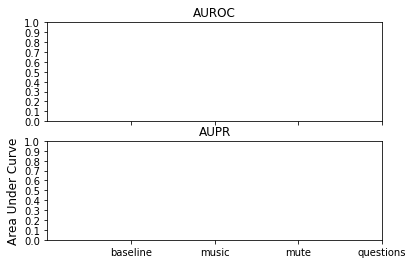

In [489]:
## INITIALIZE PLOT ##
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)

y_ticks = plt.yticks(np.arange(11)/10)
x_ticks = plt.xticks(np.arange(1, len(states.columns)+1), states.columns)

plt.ylabel('Area Under Curve', fontsize='large')
plt.autoscale(enable = False, tight=False, axis = 'y')
ax[0].set_title('AUROC')
ax[1].set_title('AUPR')

In [490]:
## AUTOMATION TIME! ##
X = data.drop('state', axis=1)
for i, state in enumerate(states.columns, start=1):

    y = states[state]
    proportion = y.mean()

    auroc_plt_data = np.array([])
    aupr_plt_data = np.array([])

    for train_index, val_index in skf.split(X, y):
        train_X, train_y = X.iloc[train_index], y.iloc[train_index]
        val_X, val_y = X.iloc[val_index], y.iloc[val_index]

        clf.fit(train_X, train_y) #re-fit model

        preds = clf.predict_proba(val_X)[:,1] #predict, probability of positive class predict

        auroc = roc_auc_score(val_y, preds)
        aupr = average_precision_score(val_y, preds)

        auroc_plt_data = np.append(auroc_plt_data, auroc)
        aupr_plt_data = np.append(aupr_plt_data, aupr)

    plot_confidence_interval(i, auroc_plt_data, axes=ax[0]) #AUROC plot
    plot_confidence_interval(i, aupr_plt_data, axes=ax[1]) #AUPR plot
    plot_baseline(proportion=proportion, x=i, axes=ax[1]) #AUPR baselines

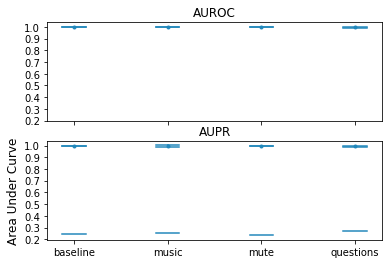

In [491]:
fig

In [492]:
## BUILD MODEL ##

#TODO: define cross validation hyperparams
n_splits = 10
skf_random = 0 #DO NOT TOUCH
shuffle=True
#TODO: define model hyperparams, can automate tuning later
loss = 'exponential'
learning_rate = 0.1
n_estimators = 100
max_depth = 3
clf_random = 0 #DO NOT TOUCH

#TODO: implement model(s)
skf = StratifiedKFold(n_splits=n_splits, random_state=skf_random, shuffle=shuffle)


models = {
    'Random Forest': RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=clf_random),
    'Decistion Tree': DecisionTreeClassifier(splitter='best', max_depth=max_depth, random_state=clf_random)
    'Nearest Neighbors': KNeighborsClassifier
}

Text(0.5, 1.0, '')

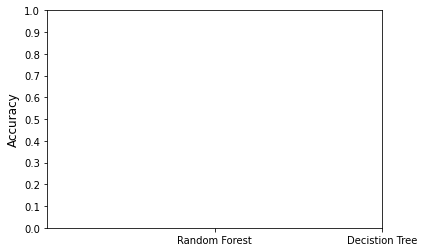

In [498]:
## INITIALIZE PLOT ##
fig2, ax2 = plt.subplots()

y_ticks = plt.yticks(np.arange(11)/10)
x_ticks = plt.xticks(np.arange(1, len(models)+1), models.keys())

plt.ylabel('Accuracy', fontsize='large')
plt.autoscale(enable = False, tight=False, axis = 'y')
ax2.set_title('')

In [499]:
X = data.drop('state', axis=1)

y = data['state']

for i, model in enumerate(models.values(), start=1):
    clf = model
    
    accuracy_plt_data = np.array([])

    for train_index, val_index in skf.split(X, y):
        train_X, train_y = X.iloc[train_index], y.iloc[train_index]
        val_X, val_y = X.iloc[val_index], y.iloc[val_index]

        clf.fit(train_X, train_y) #re-fit model

        preds = clf.predict(val_X)

        accuracy = (preds == val_y).mean()
        accuracy_plt_data = np.append(accuracy_plt_data, accuracy)

    plot_confidence_interval(i, accuracy_plt_data, axes=ax2)

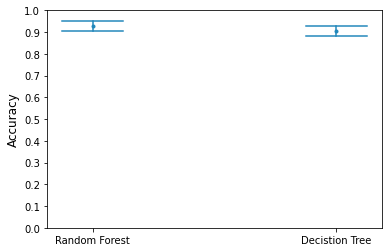

In [500]:
fig2